Stress test:
- There are 5531452 rows in the csv file in total (including header)
- It takes 3m31s to read train_data.csv

In [41]:
# N = sum(1 for line in open('data/train_data.csv'))
# N
# print(sum(1 for line in open('data/train_labels.csv')))

458914


In [39]:
# df = pd.read_csv('data/train_data.csv')
# labels = pd.read_csv('data/train_labels.csv')

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
features = pd.read_csv('data/train_data.csv')
labels = pd.read_csv('data/train_labels.csv')

#### Categorize columns by type: 

In [2]:
features.dtypes.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [3]:
obj_cols = features.select_dtypes(include=['O']).columns
obj_cols

Index(['customer_ID', 'S_2', 'D_63', 'D_64'], dtype='object')

In [4]:
int_cols = features.select_dtypes(include=['int64']).columns
int_cols

Index(['B_31'], dtype='object')

In [5]:
print('B_31', features.B_31.unique())
for col in obj_cols.drop(['customer_ID', 'S_2']): # S_2 is a date
    print(col, features[col].unique())

B_31 [1 0]
D_63 ['CR' 'CO' 'CL' 'XZ' 'XM' 'XL']
D_64 ['O' 'R' nan 'U' '-1']


In [6]:
float_cols = features.select_dtypes(include=['float64']).columns
float_cols

Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
       'D_43',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=185)

In [7]:
nullcols = []
for col in features:
    if features[col].isnull().values.any():
        nullcols.append(col)
len(nullcols)

122

#### Generate distribution histograms of the columns:

In [8]:
"""
# features.hist(bins=20, figsize=(60, 40))
"""

'\n# features.hist(bins=20, figsize=(60, 40))\n'

## Preprocessing

Define some useful functions:

In [9]:
def get_sample(size):
    prng = np.random.RandomState(0)
    g = features.groupby('customer_ID')

    portion = features[g.ngroup().isin(prng.choice(g.ngroups, size, replace=False))]
    return portion

# sample1 = get_sample(g.ngroups//100)
sample2 = get_sample(1000)

In [10]:
def get_y(ids):
    label_lookup = dict()
    for id in ids:
        if id not in label_lookup:
            target = labels.loc[labels.customer_ID == id, 'target']
            label_lookup[id] = target.iloc[0]

    return pd.Series([label_lookup[id] for id in ids], index=ids)
    # for id in features.customer_ID.unique():
    #     if len(features.loc[features.customer_ID == id, 'target'].unique()) != 1:
    #         print(features.loc[features.customer_ID == id])
    
# sample2y = get_y(sample2['customer_ID'])
# sample2y

In [11]:
"""
from sklearn.impute import SimpleImputer
sample2copy = sample2.copy()
sample2copy.index = sample2copy['customer_ID']
fitted_imputers = sample2copy.groupby(sample2copy.index).apply(lambda df: SimpleImputer(strategy='most_frequent').fit(df[['D_64', 'D_63']]))
fitted_imputers = {fitted_imputers.index[i] : fitted_imputers.iloc[i] for i in range(len(fitted_imputers))}

transformed = sample2copy.groupby(sample2copy.index).apply(
    lambda df: pd.DataFrame(
        fitted_imputers[df.index[0]].transform(df[['D_64', 'D_63']]), 
    ))
transformed.reset_index()
transformed.index = sample2copy.index
pd.DataFrame(transformed)
# type(fitted_imputers)

# imputer = SimpleImputer(strategy='most_frequent').fit(sample2copy[['D_64']])
# transformed_column = imputer.transform(sample2copy[['D_64']])
# transformed_column
"""

"\nfrom sklearn.impute import SimpleImputer\nsample2copy = sample2.copy()\nsample2copy.index = sample2copy['customer_ID']\nfitted_imputers = sample2copy.groupby(sample2copy.index).apply(lambda df: SimpleImputer(strategy='most_frequent').fit(df[['D_64', 'D_63']]))\nfitted_imputers = {fitted_imputers.index[i] : fitted_imputers.iloc[i] for i in range(len(fitted_imputers))}\n\ntransformed = sample2copy.groupby(sample2copy.index).apply(\n    lambda df: pd.DataFrame(\n        fitted_imputers[df.index[0]].transform(df[['D_64', 'D_63']]), \n    ))\ntransformed.reset_index()\ntransformed.index = sample2copy.index\npd.DataFrame(transformed)\n# type(fitted_imputers)\n\n# imputer = SimpleImputer(strategy='most_frequent').fit(sample2copy[['D_64']])\n# transformed_column = imputer.transform(sample2copy[['D_64']])\n# transformed_column\n"

#### Pipeline:
- Apply OHE/MEstimate
- Combine IDs
- Impute missing values
- (PCA)
- (KMeans)
- Train
- Predict
- Cross validate

In [12]:
from lib2to3.pytree import Base
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sqlalchemy import Column

class ByIndexTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, transformer, cnames = None):
        self.cnames = cnames
        self.transformer = transformer
    def fit(self, X: pd.DataFrame, y = None):
        self.fitted_transformers = X.groupby(X.index).apply(
            lambda df: self.transformer.fit(df if self.cnames == None else df[self.cnames]))
        self.fitted_transformers = {self.fitted_transformers.index[i] : self.fitted_transformers.iloc[i] for i in range(len(self.fitted_transformers))}
        return self
    def transform(self, X: pd.DataFrame, y = None):
        transformed = X.groupby(X.index).apply(
            lambda df: pd.DataFrame(
                self.fitted_transformers[df.index[0]]
                .transform(df if self.cnames == None else df[self.cnames])
            )
        )
        transformed.reset_index()
        transformed.index = X.index
        return transformed
        
"""
# class DFTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self, cnames)

# class IDFolder(BaseEstimator, TransformerMixin):
#     def __init__(self, id_name: str):
#         self.id_name = id_name
#     def fit(self, X, y = None):
#         return self
#     def transform(self, X, y = None):
#         return X.groupby(self.id_name).apply(lambda df: df.mean()).unstack().reset_index()

# # class EncoderWrapper(BaseEstimator, TransformerMixin):
# #     def __init__(self, encoder):
# #         self.encoder = encoder
# #     def fit(self, X: np.ndarray, y = None):
# #         self.encoder.fit(X, y)
# #         return self
# #     def transform(self, X: np.ndarray, y = None):
# #         encoded_cols = self.encoder.transform(X)
# #         encoded_df = pd.DataFrame(encoded_cols)
# #         return encoded_df

# def column_types(features: pd.DataFrame):
#     categoricals = []
#     objects = []
#     numericals = []
#     for cname in features.columns:
#         col = features[cname]
#         if col.dtype == 'object':
#             if col.nunique() < 10:
#                 categoricals.append(cname)
#             else:
#                 objects.append(cname)
#         elif col.dtype in ['int64', 'float64']:
#             numericals.append(cname)
#         else:
#             print(f"{cname}: no column category matched")
#     return categoricals, numericals, objects

# def preprocess(features: pd.DataFrame, y = None):
#     categoricals, numericals, objects = column_types(features)
    
#     # Preprocesses categoricals
#     onehot = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
#     ])
#     transformers = ColumnTransformer(transformers=[
#         ('cat', onehot, categoricals)
#     ], remainder='passthrough')
    
#     encoded_cols = transformers.fit_transform(features)
#     df = pd.DataFrame(encoded_cols)
#     print(encoded_cols)

#     df = df.groupby('customer_ID').apply(lambda df: df.mean()).unstack().reset_index()

#     return df

# # X = sample2.drop('D_64', axis=1)
# # X = preprocess(X)
# # X.head()
"""

'\n# class DFTransformer(BaseEstimator, TransformerMixin):\n#     def __init__(self, cnames)\n\n# class IDFolder(BaseEstimator, TransformerMixin):\n#     def __init__(self, id_name: str):\n#         self.id_name = id_name\n#     def fit(self, X, y = None):\n#         return self\n#     def transform(self, X, y = None):\n#         return X.groupby(self.id_name).apply(lambda df: df.mean()).unstack().reset_index()\n\n# # class EncoderWrapper(BaseEstimator, TransformerMixin):\n# #     def __init__(self, encoder):\n# #         self.encoder = encoder\n# #     def fit(self, X: np.ndarray, y = None):\n# #         self.encoder.fit(X, y)\n# #         return self\n# #     def transform(self, X: np.ndarray, y = None):\n# #         encoded_cols = self.encoder.transform(X)\n# #         encoded_df = pd.DataFrame(encoded_cols)\n# #         return encoded_df\n\n# def column_types(features: pd.DataFrame):\n#     categoricals = []\n#     objects = []\n#     numericals = []\n#     for cname in features.co

Data Imputation:

In [13]:
X = sample2.copy().drop('S_2', axis=1)
X.index = X.customer_ID
for cname in X.select_dtypes(["object"]).drop('customer_ID', axis=1):
    X[cname], _ = X[cname].factorize()

discretes = (X.dtypes == 'int64').drop('customer_ID')
d, n = [], []
for cname in X.columns:
    if cname == 'customer_ID':
        continue
    if X[cname].dtype == 'int64':
        d.append(cname)
    else:
        n.append(cname)

default_col_values = {cname: X[cname].mean() for cname in n}
def process_group(col_defaults: dict, df: pd.DataFrame):
    for cname in df.columns:
        if df[cname].isna().all():
            df[cname].fillna(col_defaults[cname], inplace=True)
    return df

X_processed = X.groupby(X.index).apply(lambda df: process_group(default_col_values, df))

num_t = ByIndexTransformer(SimpleImputer(verbose=100), n)
nums = num_t.fit_transform(X_processed)
nums.columns = n

imputed = nums.copy()
imputed[d] = X[d]
imputed

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_139,D_140,D_141,D_142,D_143,D_144,D_145,D_63,D_64,B_31
customer_ID,,,,,,,,,,,,,,,,,,,,,
001404030d4c78b76bf02e809387611bdf6b708a42c5890ecc057970b51bff87,0.523405,0.008376,0.006680,1.000940,0.003428,0.401315,0.007045,0.009355,0.183422,0.355097,...,0.008365,0.008801,0.001185,0.399193,0.006018,0.009393,0.003585,0,0,1
001404030d4c78b76bf02e809387611bdf6b708a42c5890ecc057970b51bff87,0.533376,0.002836,0.007121,0.814569,0.001009,0.394459,0.000565,0.011885,0.183422,0.312375,...,0.006429,0.000438,0.004144,0.399193,0.002282,0.003261,0.002704,0,0,1
001404030d4c78b76bf02e809387611bdf6b708a42c5890ecc057970b51bff87,0.634030,0.005452,0.004289,0.812784,0.000545,0.209648,0.004533,0.003436,0.183422,0.292273,...,0.004221,0.007356,0.002904,0.399193,0.002599,0.005015,0.009224,0,0,1
001404030d4c78b76bf02e809387611bdf6b708a42c5890ecc057970b51bff87,0.581146,0.008479,0.058330,0.818535,0.001734,0.270682,0.005404,0.000965,0.183422,0.263852,...,0.003387,0.001938,0.006487,0.399193,0.002336,0.004986,0.009904,0,0,1
001404030d4c78b76bf02e809387611bdf6b708a42c5890ecc057970b51bff87,0.638761,0.001563,0.074599,0.810576,0.003550,0.346932,0.002158,0.007989,0.183422,0.250307,...,0.003324,0.009098,0.002901,0.399193,0.009378,0.004077,0.000444,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff935ab3afd19b6876a89a865e8fd0c9ddf70df583f76b9b9a31e25564e479f0,0.694359,0.002467,0.004647,0.819456,0.008337,0.218629,0.001154,0.005749,0.183422,0.004996,...,0.005413,0.002154,0.002496,0.399193,0.005139,0.000904,0.003520,0,1,1
ff935ab3afd19b6876a89a865e8fd0c9ddf70df583f76b9b9a31e25564e479f0,0.703078,0.008550,0.006564,0.813531,0.009143,0.218629,0.005057,0.008314,0.183422,0.006044,...,0.007718,0.002808,0.009736,0.399193,0.009443,0.005709,0.003947,0,1,1
ff935ab3afd19b6876a89a865e8fd0c9ddf70df583f76b9b9a31e25564e479f0,0.703935,0.006113,0.006865,0.817879,0.001657,0.218629,0.000430,0.005133,0.183422,0.007559,...,0.008367,0.003879,0.005927,0.399193,0.009009,0.009374,0.008034,0,1,1


Mutual Information scores:

In [14]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y, discretes):
    mi_scores = mutual_info_classif(X, y, discrete_features=discretes)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

imputed_y = get_y(imputed.index)
mi_scores = make_mi_scores(imputed, imputed_y, discretes)
mi_scores.head(10)

B_16    0.571920
B_32    0.571920
D_65    0.571920
D_77    0.215330
P_2     0.208755
B_17    0.177197
D_48    0.164498
D_61    0.147662
B_9     0.141384
D_75    0.140182
Name: MI Scores, dtype: float64

In [15]:
mi_scores.tail(10)

D_88     0.000974
B_42     0.000443
B_41     0.000000
S_18     0.000000
R_18     0.000000
D_87     0.000000
S_17     0.000000
D_116    0.000000
S_6      0.000000
B_31     0.000000
Name: MI Scores, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023A945C5588>,
      dtype=object)

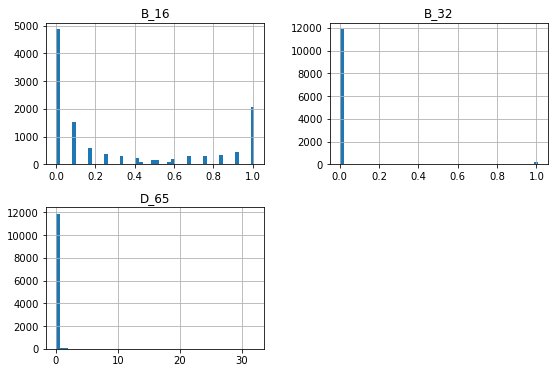

In [42]:
# B_16, B_32, D_65 have the same MI score?
# There's also a few columns with no MI

imputed[['B_16', 'B_32', 'D_65']].hist(bins=50, figsize=(9, 6)) # 13 categories?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000238AE154BE0>,
      dtype=object)

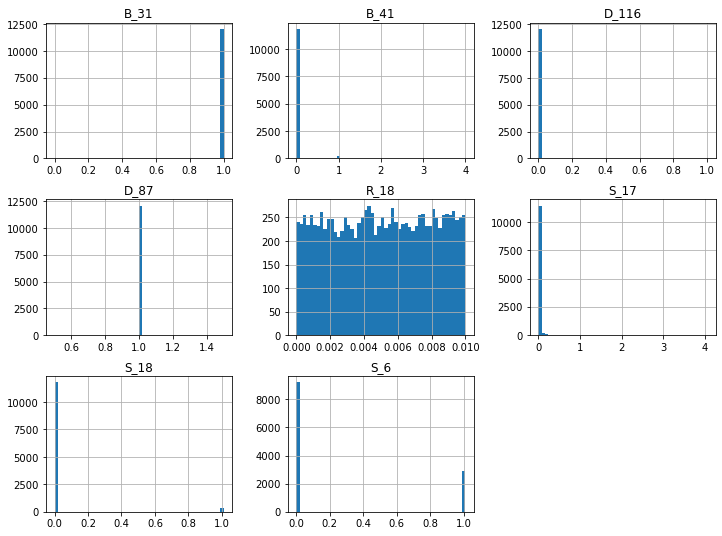

In [44]:
imputed[mi_scores.tail(8).index].hist(bins=50, figsize=(12, 9))